## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import os

from utils import *

## Importing Data

In [2]:
ticker = 'AAPL'
today = pd.Timestamp.now().strftime("%Y-%m-%d")

if not os.path.exists(f'{ticker}_{today}.csv'):
    df = get_data(ticker, interval='1d', period='10y')
    df.to_csv(f'{ticker}_{today}.csv')
else:
    df = pd.read_csv(f'{ticker}_{today}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-03-13,27.601065,28.005289,27.375505,27.781961,207309200
2015-03-16,27.904795,27.904795,27.440274,27.665834,143497200
2015-03-17,28.371548,28.434079,28.061122,28.116954,204092400
2015-03-18,28.690905,28.845001,28.221917,28.362613,261083600
2015-03-19,28.474279,28.865103,28.451947,28.753439,183238000


## Price Chart

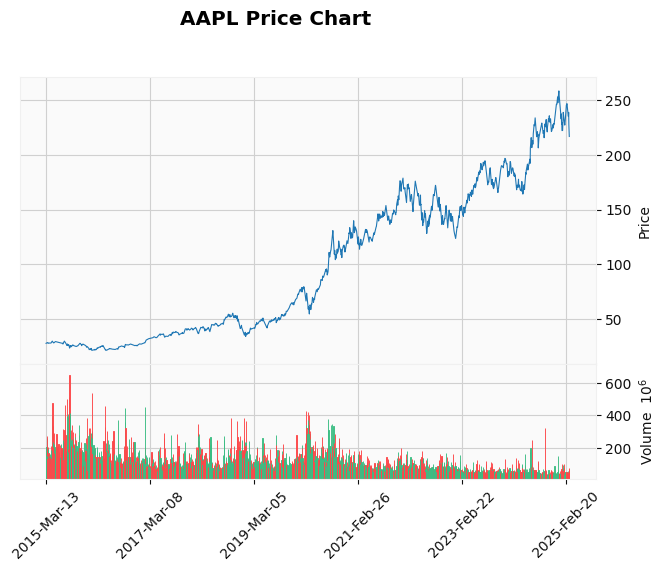

In [4]:
price_chart(df, title=f'{ticker} Price Chart')


## Generating Technical Indicators

In [5]:
df.ta.rsi(length=14, append=True) 
df.ta.ema(length=20, append=True)
df.ta.ema(length=50, append=True)
df.ta.ema(length=200, append=True) 



# drop rows with NaN values because of shift in EMA calculation
df.dropna(inplace=True)

# we determined from feature importance on random forest that Open, High, Low are not important
df.drop(columns=['Open', 'High', 'Low'], inplace=True) 

df.tail()

,Close,Volume,RSI_14,EMA_20,EMA_50,EMA_200
Date,,,,,,
2025-03-06,235.330002,45170400,45.112604,238.689576,237.890055,224.761873
2025-03-07,239.070007,46273600,50.801949,238.725808,237.936328,224.904243
2025-03-10,227.479996,72071200,37.744918,237.654778,237.526276,224.929872
2025-03-11,220.839996,76137400,32.578762,236.053370,236.871912,224.889177
2025-03-12,216.979996,62466400,30.007519,234.236859,236.091837,224.810479


## Defining entry points

In [6]:
df['buy'] = (
    (df['RSI_14'] < 45) &  
    (df['EMA_20'] >= 0.98 * df['EMA_50']) &  
    (df['Close'] >= 0.95 * df['EMA_200'])
).astype(int)

# save df with indicators and buy columns
#df.to_csv(f'TA_AAPL_{pd.Timestamp.now().strftime("%Y-%m-%d")}.csv')

df['buy'].value_counts()

buy
0    1971
1     345
Name: count, dtype: int64

<Axes: >

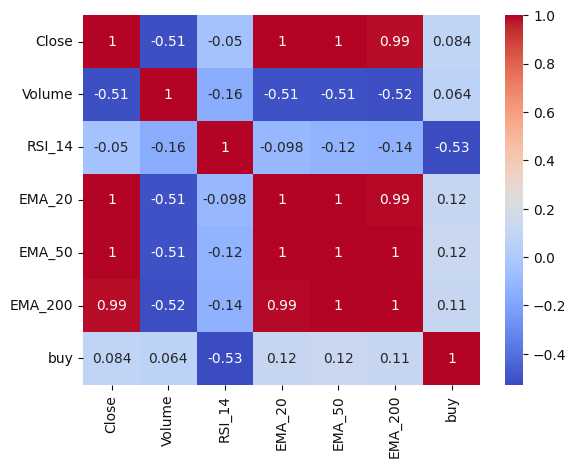

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Classifying the data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data splitting

In [9]:
train_pct = 0.8
train_size = int(train_pct * len(df))
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(columns=['buy'])
y_train = train['buy']

X_test = test.drop(columns=['buy'])
y_test = test['buy']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest training

In [10]:
classifier_RR = RandomForestClassifier(n_estimators=50, random_state=42)
classifier_RR.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### Model evaluation

In [11]:
y_pred_RR = classifier_RR.predict(X_test_scaled)

print(classification_report(y_test, y_pred_RR))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       364
           1       0.77      0.99      0.87       100

    accuracy                           0.94       464
   macro avg       0.89      0.96      0.91       464
weighted avg       0.95      0.94      0.94       464



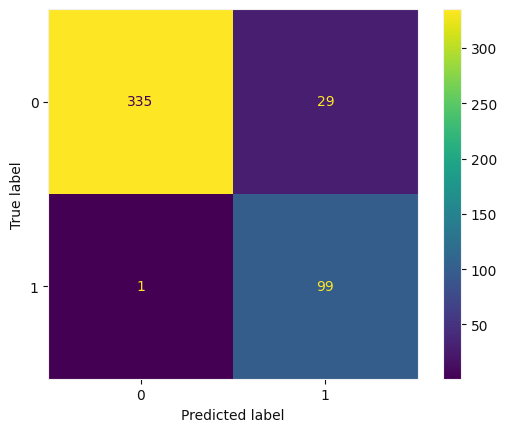

In [12]:
cm = confusion_matrix(y_test, y_pred_RR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### features importance

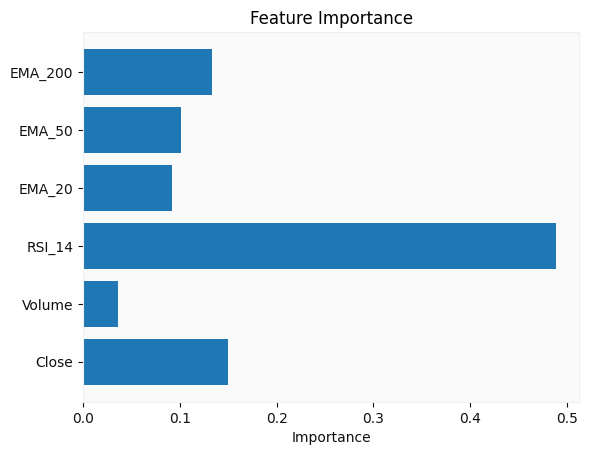

In [13]:
plt.barh(X_train.columns, classifier_RR.feature_importances_)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### SVM and KNN training

In [14]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'], 
    'kernel': ['rbf']
}


svm = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(svm, param_grid, 
                           scoring=['f1', 'accuracy'],
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train_scaled, y_train)


print('param:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_svm = grid_search.best_estimator_


y_pred_svm = best_svm.predict(X_test_scaled)
print('SVM Classification Report:\n', classification_report(y_test, y_pred_svm))
confusion_matrix(y_test, y_pred_svm)

param: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
f1: 0.670836259834473
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       364
           1       0.83      0.65      0.73       100

    accuracy                           0.90       464
   macro avg       0.87      0.81      0.83       464
weighted avg       0.89      0.90      0.89       464



array([[351,  13],
       [ 35,  65]])

In [15]:
param_grid = {
    'n_neighbors': range(1, 21),
    'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}


knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid,
                           scoring=['f1', 'accuracy'], 
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train_scaled, y_train)


print('params:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_knn = grid_search.best_estimator_


y_pred_knn = best_knn.predict(X_test_scaled)
print('KNN Classification Report:\n', classification_report(y_test, y_pred_knn))
confusion_matrix(y_test, y_pred_knn)

params: {'n_neighbors': 5, 'p': 2}
f1: 0.491986497713982
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       364
           1       0.73      0.82      0.77       100

    accuracy                           0.89       464
   macro avg       0.84      0.87      0.85       464
weighted avg       0.90      0.89      0.90       464



array([[333,  31],
       [ 18,  82]])